# Train a CNN on LSE cycles for BMI prediction from gait.

In [1]:
# Imports
import tables
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import threading
import pickle
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.utils import class_weight

Using TensorFlow backend.


In [2]:
# =============================================================================
# PARAMETERS
# =============================================================================

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
label_table_file = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/all.tsv"
train_data_path = r"/scratch/PI/euan/projects/mhc/code/daniel_code/data/BMI_cycles.hdf5"

#Training metrics
model_metrics = ['mse', 'mae']

#Training parameters
batch_size = 512
canMultiprocess = False

# Data visualization and processing

In [3]:
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    print(file)

/scratch/PI/euan/projects/mhc/code/daniel_code/data/BMI_cycles.hdf5 (File) 'cycles'
Last modif.: 'Thu Jul 18 14:21:53 2019'
Object Tree: 
/ (RootGroup) 'cycles'
/data (EArray(217070, 100, 4)) ''
/labels (EArray(217070,)) ''



(100, 300)


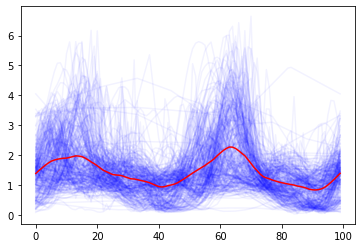

In [4]:
#Visualize some data points
with tables.open_file(train_data_path, mode='r') as file:
    subset = file.root.data[0:300, :, -1].T
    print(subset.shape)
    plt.plot(subset, color='b', alpha=0.05)
    plt.plot(np.mean(subset, axis=1), color ='r')

In [11]:
#Look at our label file
def get_BMI_table():
    table_folder = "/scratch/PI/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, 'cardiovascular-NonIdentifiableDemographicsTask-v2.tsv')

    df = pd.read_csv(table_path, sep='\t')
    df = df[['healthCode', 
             'NonIdentifiableDemographics.json.patientWeightPounds',
             'NonIdentifiableDemographics.json.patientHeightInches', 
             'NonIdentifiableDemographics.patientWeightPounds',
             'NonIdentifiableDemographics.patientHeightInches',]]
             #'NonIdentifiableDemographics.json.patientWakeUpTime',
             #'NonIdentifiableDemographics.json.patientCurrentAge', 
             #'NonIdentifiableDemographics.json.patientGoSleepTime']]

    print(f"Starting with {df.shape[0]} records")
    
    #Encode to bytes
    df['healthCode'] = df['healthCode'].map(lambda x: x.encode('UTF-8'))

    #Merge weights and heights
    df['Weight'] = df['NonIdentifiableDemographics.patientWeightPounds'].fillna(df['NonIdentifiableDemographics.json.patientWeightPounds'])
    df['Height'] = df['NonIdentifiableDemographics.patientHeightInches'].fillna(df['NonIdentifiableDemographics.json.patientHeightInches'])
    df = df[['healthCode', 'Weight', 'Height']]

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")


    df = df[df['Weight'] < 1000]
    df = df[df['Weight'] > 10]
    print(f"Dropping invalid weights (10 > w or w > 1000 pounds) gives {df.shape[0]} users")

    df = df[df['Height'] < 96]
    df = df[df['Height'] > 36]
    print(f"Dropping invalid weights (36 inches (3ft) > h or h > 96 inches (8ft)) gives {df.shape[0]} users")
        
    df['BMI'] = 703*(df['Weight'] / df['Height']) / df['Height']
    
    return df

label_df = get_BMI_table()

#Access a label like this
print(label_df.loc[label_df.index[0], 'BMI'])

Starting with 48285 records
Dropping NaNs gives 41982 users
Dropping duplicate healthcodes gives 23448 users
Dropping invalid weights (10 > w or w > 1000 pounds) gives 21127 users
Dropping invalid weights (36 inches (3ft) > h or h > 96 inches (8ft)) gives 21042 users
19.366391184573004


Starting with 48285 records
Dropping NaNs gives 41982 users
Dropping duplicate healthcodes gives 23448 users
Dropping invalid weights (10 > w or w > 1000 pounds) gives 21127 users
Dropping invalid weights (36 inches (3ft) > h or h > 96 inches (8ft)) gives 21042 users
(128, 1, 4, 100)


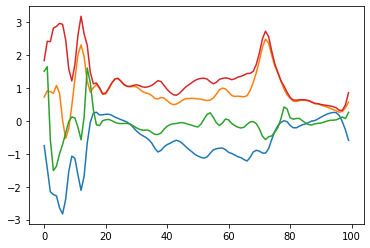

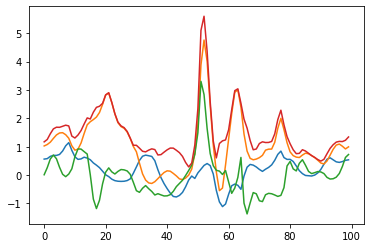

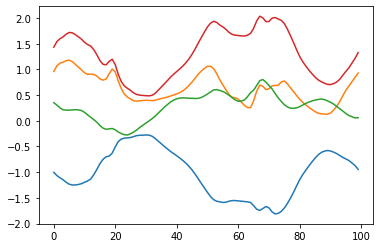

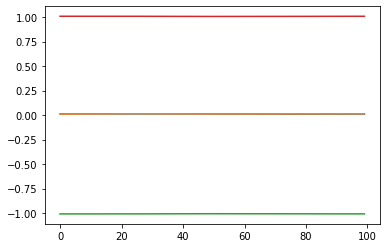

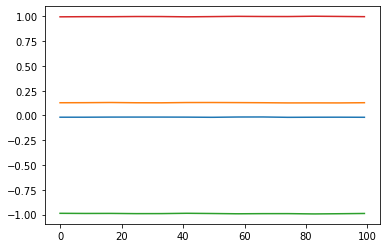

In [12]:
# =============================================================================
# Data generator
# =============================================================================
def parse_label(code, label_df):
    """
    Helper function that parses the labels on survey data for a given code
    """
    
    return label_df.loc[code, 'BMI']
        
class SixMWTSequence(keras.utils.Sequence):
    '''
    SixMWTSequence
    Extends keras inbuilt sequence to create a data generator
    Saves on RAM by loading data from hdf5 files in memory
    Shuffle increases read time by 20x but makes the batches mixed
    '''
    def __init__(self, data_file, batch_size, label_df, shuffle=True, val=False, val_split = 0.7):
        #Open up file
        #self.lock = threading.Lock()
        self.data = data_file.root.data
        self.labels = data_file.root.labels
        
        #Track labels and batch size
        self.label_map = label_df
        self.batch_size = batch_size
        self.inval_hc = set()
        self.val = val
        self.val_split = val_split
        
        #Partition the dataset into batches
        if val:
            num_data = int(self.labels.shape[0] * (1-val_split))
            self.order = np.arange(self.labels.shape[0] - num_data, self.labels.shape[0])
        else:
            num_data = int(self.labels.shape[0] * val_split)
            self.order = np.arange(num_data)
            
        self.length = num_data // self.batch_size
                
        #Shuffle
        if(shuffle):
            np.random.shuffle(self.order)        

    def __len__(self):

        return self.length

    def __getitem__(self, idx):
        
        start_idx = idx*self.batch_size
        stop_idx = (idx + 1)*self.batch_size
                    
        idxs = self.order[start_idx:stop_idx]
        
        #Get the batch members
        batch_x = np.array([self.data[idx] for idx in idxs])
        y_healthcodes = np.array([self.labels[idx] for idx in idxs])
                
        #Convert healthcodes to ages
        batch_y = np.empty(len(y_healthcodes))
        for i in range(len(batch_y)):
            
            batch_y[i] = parse_label(y_healthcodes[i], self.label_map)
                
        #Normalize over time dimension
        #print(np.mean(batch_x, axis = -2))

        #batch_x -= np.expand_dims(np.mean(batch_x, axis = 1), axis=1)
        #batch_x = keras.utils.normalize(batch_x, axis=2)
        #print(np.mean(batch_x, axis = -2))
            
        #Add a extra dimension
        batch_x = np.expand_dims(batch_x, axis=1)
        #Swap axes
        batch_x = np.swapaxes(batch_x, -1, -2)
            
        return batch_x, batch_y

label_df = get_BMI_table()
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    print(train_gen[20][0].shape)
    window = train_gen[20][0]
    
    for i in range(5):
        plt.figure()
        plt.plot(window[i, :, :].squeeze().T)
        plt.show()

In [14]:
#Make a baby validation dataset
X_val = np.empty((0, 1, 4, 100))
y_val = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)  
    for batch_x, batch_y in val_gen:
        X_val = np.concatenate((X_val, batch_x), axis=0)
        y_val = np.concatenate((y_val, batch_y), axis=0)

In [15]:
#Make a baby train dataset in memory
X_train = np.empty((0, 1, 4, 100))
y_train = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)  
    for batch_x, batch_y in train_gen:
        X_train = np.concatenate((X_train, batch_x), axis=0)
        y_train = np.concatenate((y_train, batch_y), axis=0)

In [22]:
#Remove invalid BMIs (> 60 or <10)
mask = np.logical_and(y_val >= 10, y_val <= 60)
X_val = X_val[mask]
y_val = y_val[mask]

mask = np.logical_and(y_train >= 10, y_train <= 60)
X_train = X_train[mask]
y_train = y_train[mask]

In [23]:
# Sanity Check
print(train_gen.inval_hc, val_gen.inval_hc)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(np.unique(y_train))

set() set()
(149060, 1, 4, 100) (65024, 1, 4, 100) (149060,) (65024,)
[12.4692287  15.34729338 16.75673869 17.10697888 17.53976387 17.7189666
 17.97297297 18.30295858 18.55945822 18.68716524 18.8822314  18.96852071
 19.12835429 19.22489796 19.39428711 19.41902428 19.46020761 19.57562932
 19.79877551 20.08571429 20.28378378 20.35865449 20.36911061 20.37265306
 20.37681159 20.4660355  20.51525952 20.52443772 20.61265432 20.65748393
 20.67186456 20.96744381 21.01948302 21.14164371 21.14167966 21.18243243
 21.29798817 21.2982847  21.33683793 21.37693878 21.41041798 21.43184681
 21.43663495 21.61575084 21.69753086 21.76674798 21.94857668 22.15131579
 22.16250704 22.19679931 22.2377551  22.27134986 22.31201172 22.31303313
 22.31746032 22.34883218 22.3755787  22.38122449 22.48364258 22.59459459
 22.64679784 22.73934047 22.78240741 22.8049308  22.88699853 22.91689624
 22.95510204 22.95696367 22.99591111 22.99853516 23.01031541 23.03465658
 23.05362654 23.07828283 23.08594483 23.10810811 23.182

[(56.85638699924414, 4343), (23.401056014692376, 716), (17.972972972972972, 2474), (24.389795918367344, 256), (26.622485207100592, 291), (24.363579080025204, 171), (24.58699042102918, 289), (22.375578703703702, 1847), (24.102857142857143, 3641), (24.886474609375, 2735), (40.44074394463668, 199), (28.188906215192695, 503), (26.496726839912714, 327), (29.17724609375, 7333), (23.42703574307982, 4649), (30.53798173312542, 436), (28.36273221992869, 197), (23.5681412418171, 316), (20.46603550295858, 680), (23.358239163433968, 455), (23.18231463978156, 306), (30.620479947403027, 310), (47.32773919753086, 384), (22.317460317460316, 371), (31.244444444444447, 348), (24.781358131487888, 397), (41.175714285714285, 228), (29.048122952884857, 331), (23.528979591836734, 141), (29.124285714285715, 359), (22.78240740740741, 230), (25.537551020408163, 992), (33.4703947368421, 413), (30.254541522491348, 203), (24.009382623381498, 414), (21.297988165680476, 410), (51.01048105348025, 1449), (33.4283673469

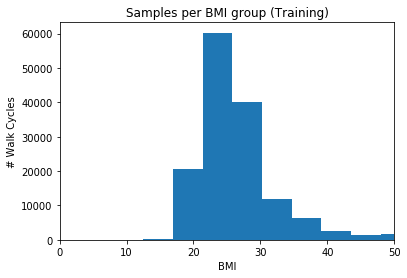

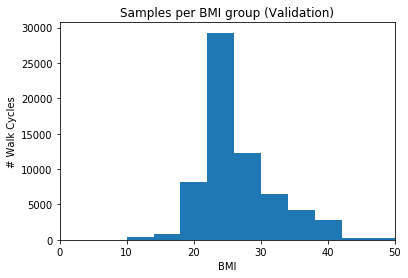

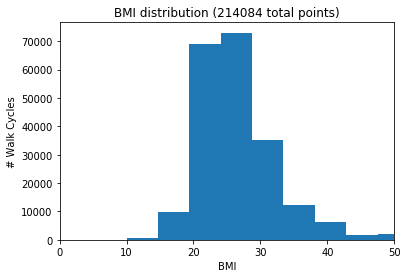

In [10]:
# profile the dataset
from collections import Counter
xs = []
ys = []
print(list(Counter(y_train).items()))
for item in Counter(y_train).items():
    xs.append(item[0])
    ys.append(item[1])

plt.figure()
plt.title("Samples per BMI group (Training)")
#plt.bar(xs, ys)
plt.hist(y_train)
plt.xlim([0, 50])
plt.xlabel("BMI")
plt.ylabel("# Walk Cycles")
plt.show()

plt.figure()
plt.title("Samples per BMI group (Validation)")
#plt.bar(xs, ys)
plt.hist(y_val)
plt.xlim([0, 50])
plt.xlabel("BMI")
plt.ylabel("# Walk Cycles")
plt.show()

plt.figure()
plt.title(f"BMI distribution ({len(y_val) + len(y_train)} total points)")
#plt.bar(xs, ys)
plt.hist(np.concatenate((y_val, y_train)))
plt.xlim([0, 50])
plt.xlabel("BMI")
plt.ylabel("# Walk Cycles")
plt.show()

In [25]:
# Save and export the data
np.save('BMI_X_train.npy', X_train)
np.save('BMI_X_val.npy', X_val)
np.save('BMI_y_train.npy', y_train)
np.save('BMI_y_val.npy', y_val)

# Training

In [ ]:
#Load old 3axis data
X_train = np.load('BMI_X_train.npy')
y_train = np.load('BMI_y_train.npy')

X_val = np.load('BMI_X_val.npy')
y_val = np.load('BMI_y_val.npy')

In [3]:
#Load 15 axis data
print('Beginning loading')
X_train = np.load('BMI_X_15.npy')
y_train = np.load('BMI_y_15.npy')
ids_train = np.load('BMI_ids_15.npy')

print('Finished loading, beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(X_train, y_train, ids_train, train_size = 0.8)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

split_num = int(0.8*X_train.shape[0])
X_val = X_train[split_num:]
y_val = y_train[split_num:]
ids_val = ids_train[split_num:]

X_train = X_train[:split_num]
y_train = y_train[:split_num]
ids_train = ids_train[:split_num]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, ids_train.shape, ids_val.shape

Beginning loading
Finished loading, beginning X_train axis adjustment
Data is NOT randomized.
Beginning data splitting


((2639860, 1, 15, 100),
 (659965, 1, 15, 100),
 (2639860,),
 (659965,),
 (2639860,),
 (659965,))

In [6]:
#Define a model
def get_model():
    model = Sequential()
    # ENTRY LAYER
    model.add(Conv1D(32, 10, activation='relu', input_shape=(100, 4)))
    model.add(BatchNormalization())

    for i in range(5):
    
        model.add(Conv1D(64, 5, activation='relu'))
        model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(40, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

In [14]:
import functools
from typing import Callable, Tuple, Union

import keras.backend as K
from keras.layers import (
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    LocallyConnected2D,
    MaxPooling2D,
    Permute,
    add,
    concatenate,
    regularizers,
    Reshape,
)


from keras.models import Model

D_FMT = dict(data_format='channels_first')
REG_P = dict(kernel_regularizer=regularizers.l2(0.001))
ACT_P = dict(activation='selu', **REG_P)
BN_P = dict(epsilon=0.23, axis=-1)

def VinNet(input_shape=None, input_tensor=(None, None), classes=1000, dropout=0.3, factor=2, regression=False):  # noqa: ignore=N802
    """
    VinNet Architecture

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Inputs
    acc_input = _create_input(input_shape=input_shape, name='acc_input')

    # Accelerometer and Conv Blocks
    x = _vinnet_body(sensor='acc')(acc_input)

    # Classification block
        # Classification block'
    if regression:
        x = Dense(1, name='predictions', **REG_P)(x)
        
    else:
        if classes == 2:
            x = Dense(1, activation = 'sigmoid', name='predictions', **REG_P)(x)

        else:
            x = Dense(classes, activation='softmax', name='predictions', **REG_P)(x)
        
    return Model(inputs=acc_input, outputs=x, name='VinNet')

def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor

def _vinnet_body(sensor='acc'):

    def layer_wrapper(inp):
        lower = _fc_lower(sensor=sensor)(inp)
        lc = _flatten_lc(sensor=sensor)(inp)

        concat = concatenate([lower, lc], axis=-1, name=f'concat_{sensor}')

        x = Dense(512, name=f'dense_top_{sensor}', **ACT_P)(concat)
        x = BatchNormalization(name=f'bn_top_{sensor}', **BN_P)(x)

        return x

    return layer_wrapper


def _fc_lower(sensor='acc'):

    _block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        c1 = _block(64, (1, 5), block=1, layer=1, padding='valid')(inp)
        c2 = _block(64, (4, 5), block=1, layer=2, padding='valid')(c1)
        c3 = _block(64, (1, 4), block=1, layer=3, padding='same')(c2)
        x = add([c2, c3], name=f'block1_resid1_{sensor}')

        for i in range(2, 6):
            c = _block(64, (1, 8), block=i, layer=1, padding='same')(x)
            x = add([x, c], name=f'block{i}_resid1_{sensor}')

        x = Reshape((1, 64, -1), name=f'reshape_fc_{sensor}')(x)
        x = Conv2D(32, (1, 8), padding='same', name=f'conv_fc_{sensor}', **ACT_P)(x)
        x = Flatten(name=f'flatten_fc_{sensor}', **D_FMT)(x)
        x = Dense(512, name=f'dense_fc_{sensor}', **ACT_P)(x)

        return x

    return layer_wrapper


def _flatten_lc(sensor='acc'):

    def layer_wrapper(inp):
        x = AveragePooling2D(pool_size=(1, 4), strides=(1, 3), name=f'avgpool_lc_{sensor}', **D_FMT)(inp)
        x = LocallyConnected2D(16, (4, 4), strides=(1, 4), name=f'local_lc_{sensor}', **ACT_P, **D_FMT)(x)
        x = Flatten(name=f'flat_lc_{sensor}', **D_FMT)(x)
        x = Reshape((-1,), name=f'reshape_lc_{sensor}')(x)
        return x

    return layer_wrapper


def _conv_layer(units, kernel_size=(1, 3), block=1, layer=1, padding='valid', sensor='acc'):

    def layer_wrapper(inp):
        x = Conv2D(units, kernel_size,
                   padding=padding,
                   name=f'block{block}_conv{layer}_{sensor}', **D_FMT, **ACT_P)(inp)
        return x

    return layer_wrapper


def _conv_block(units, kernel_size=(1, 3), block=1, layer=1, padding='valid', sensor='acc'):
    """
        # Arguments
            units: conv filters
            block: block number within network (used for naming)
            layer: layer number within block (used for naming)
            sensor: sensor name (used for naming)

        # Returns
            callable
    """

    def layer_wrapper(inp):
        x = _conv_layer(units, kernel_size, block, layer, padding, sensor)(inp)
        x = BatchNormalization(name=f'block{block}_bn{layer}_{sensor}', **BN_P)(x)
        return x

    return layer_wrapper

In [10]:
import functools
import json

import keras.backend as K

from keras.layers import Permute, Dense, Input, Conv2D, concatenate, MaxPooling2D
from keras.layers import ELU, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model

# %load model_util
from keras.layers import Input

def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor


def _conv_block(units, block=1, layer=1, sensor='acc'):
    """
    Create VGG style convolutional block.

    Deviations from original paper.
        - Remove `Dropout`
        - Added `BatchNormalization`
        - He-normal initialization
        - Uses `ELU` Activation
        
    # Arguments
        units: conv filters
        block: block number within network (used for naming)
        layer: layer number within block (used for naming)
        sensor: sensor name (used for naming)
        
    # Returns
        callable
    """
    def layer_wrapper(inp):
        x = Conv2D(units, (1, 3), padding='same', kernel_initializer='he_normal',
                   name=f'block{block}_conv{layer}_{sensor}')(inp)
        x = BatchNormalization(epsilon=0.23, name=f'block{block}_bn{layer}_{sensor}')(x)
        x = ELU(name=f'block{block}_act{layer}_{sensor}')(x)
        return x

    return layer_wrapper


def _dense_block(units, dropout=0.3, name='fc1'):
    """
    Create VGG fully connected block.

    # Deviations from original paper.
        - Added `BatchNormalization`
        - Uses `ELU` Activation
    
    # Arguments
        units: fc layer dimensionality
        dropout: dropout probability
        name: prefix for dense layers

    # Returns
        callable
    """

    def layer_wrapper(inp):
        x = Dense(units, name=f'{name}')(inp)
        x = BatchNormalization(epsilon=0.23, name=f'{name}_bn')(x)
        x = ELU(name=f'{name}_act')(x)
        x = Dropout(dropout, name=f'{name}_dropout')(x)
        return x

    return layer_wrapper


def _vgg_body(factor=2, sensor='acc'):
    """
    VGG Network Body containing convolutional blocks
    
    # Arguments
        factor: scaling factor to reduce network filter width
        sensor: sensor name
        
    # Return
        callable
    """

    _vgg_conv_block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        x = Permute((1, 3, 2), name=f'swapaxes_{sensor}')(inp)

        # Block 1
        x = _vgg_conv_block(64 // factor, block=1, layer=1)(x)
        x = _vgg_conv_block(64 // factor, block=1, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block1_pool_{sensor}')(x)

        # Block 2
        x = _vgg_conv_block(128 // factor, block=2, layer=1)(x)
        x = _vgg_conv_block(128 // factor, block=2, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block2_pool_{sensor}')(x)

        # Block 3
        x = _vgg_conv_block(256 // factor, block=3, layer=1)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=2)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block3_pool_{sensor}')(x)

        # Block 4
        x = _vgg_conv_block(512 // factor, block=4, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block4_pool_{sensor}')(x)

        # Block 5
        x = _vgg_conv_block(512 // factor, block=5, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block5_pool_{sensor}')(x)

        return x

    return layer_wrapper

def VGG16Net(input_shape=None, input_tensor=(None, None),
             classes=1000, dropout=0.3, factor=2, regression=False):
    """
    Modified VGG architecture
        https://arxiv.org/abs/1409.1556

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width
        regression: whether last layer is regression predictor. If true, ignores the classes argument

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Two Inputs
    img_input_acc = _create_input(input_shape, input_tensor=input_tensor[0], name='acc_input')

    # Accelerometer and Gyroscope Conv Blocks
    x = _vgg_body(factor=factor, sensor='acc')(img_input_acc)

    # Merge and Pool Channels
    x = GlobalAveragePooling2D(name='avgpool')(x)

    # FC Layers
    x = _dense_block(4098 // factor, dropout=dropout, name='fc1')(x)
    x = _dense_block(4098 // factor, dropout=dropout, name='fc2')(x)

    # Classification block'
    if regression:
        x = Dense(1, name='predictions')(x)
        
    else:
        if classes == 2:
            x = Dense(1, activation = 'sigmoid', name='predictions')(x)

        else:
            x = Dense(classes, activation='softmax', name='predictions')(x)

    return Model(img_input_acc, x, name='VGG16Net')

from keras.callbacks import ModelCheckpoint

class MultiGPUCheckpoint(ModelCheckpoint):
    """
    Drop in replacement for `ModelCheckpoint` callback which fixes a bug
    when saving models wrapped in `keras.utils.multi_gpu_model`.

    Please see:
        https://github.com/keras-team/keras/issues/8123#issuecomment-409395274

    Works with both single and multi-gpu configurations.
    """
    def set_model(self, model):
        layer = model.layers[-2]
        if isinstance(layer, Model) and layer.input_names == model.input_names:
            self.model = layer
        else:
            self.model = model
                

In [15]:
#Set the model up
#model = get_mod_model()
model = VinNet(input_shape = (1, 15, 100), regression=True)
#model = VGG16Net(input_shape=(1, 15, 100), regression=True)

print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='mse',
              optimizer=adam,
              metrics=model_metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
acc_input (InputLayer)          (None, 1, 15, 100)   0                                            
__________________________________________________________________________________________________
block1_conv1_acc (Conv2D)       (None, 64, 15, 96)   384         acc_input[0][0]                  
__________________________________________________________________________________________________
block1_bn1_acc (BatchNormalizat (None, 64, 15, 96)   384         block1_conv1_acc[0][0]           
__________________________________________________________________________________________________
block1_conv2_acc (Conv2D)       (None, 64, 12, 92)   81984       block1_bn1_acc[0][0]             
__________________________________________________________________________________________________
block1_bn2

In [16]:
#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

#tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
#                 write_graph=False,) 
                 #histogram_freq=5, 
                 #embeddings_freq=5, 
                 #embeddings_layer_names=['fc1'],
                 #mbeddings_data = X_val)

cb_list = [reduce_lr, early_stop]

In [17]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs=1000,
                    validation_data = (X_val, y_val),
                    callbacks = cb_list,
                    shuffle=True,
                    batch_size = batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 2639860 samples, validate on 659965 samples
Epoch 1/1000
2639860/2639860 [==============================] - 1061s 402us/step - loss: 40.0255 - mean_squared_error: 38.0357 - mean_absolute_error: 4.1012 - val_loss: 33.3324 - val_mean_squared_error: 30.5162 - val_mean_absolute_error: 4.0268
Epoch 2/1000
2639860/2639860 [==============================] - 1038s 393us/step - loss: 18.3535 - mean_squared_error: 15.1356 - mean_absolute_error: 2.7476 - val_loss: 33.8027 - val_mean_squared_error: 30.3662 - val_mean_absolute_error: 3.9490
Epoch 3/1000
2639860/2639860 [==============================] - 1039s 393us/step - loss: 15.9115 - mean_squared_error: 12.3496 - mean_absolute_error: 2.4305 - val_loss: 34.1035 - val_mean_squared_error: 30.4758 - val_mean_absolute_error: 3.9768

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/1000
2639860/2639860 [==============================] - 1036s 393us/step -

KeyboardInterrupt: 

# Visualize Results

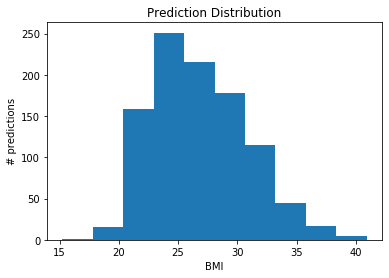

In [18]:
#Example predictions
pred = model.predict(X_val[:1000], batch_size = batch_size)

plt.figure()
plt.title('Prediction Distribution')
plt.xlabel('BMI')
plt.ylabel('# predictions')
plt.hist(pred)
plt.show()

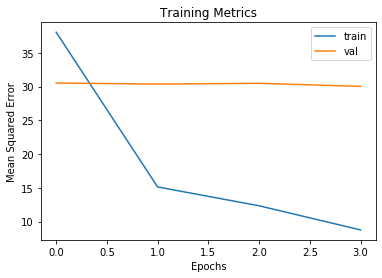

In [19]:
plt.figure()
history = model.history
plt.plot(history.history['mean_squared_error'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Metrics')
plt.show()

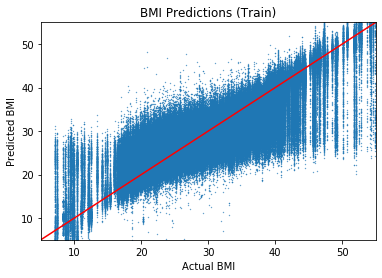

AttributeError: module 'scipy' has no attribute 'stats'

In [20]:
y_pred = model.predict(X_train, batch_size = batch_size)
plt.figure()
plt.scatter(y_train, y_pred, s=0.1)
plt.plot([5, 55], [5, 55], 'r-')
plt.xlim([5, 55])
plt.ylim([5, 55])
plt.title("BMI Predictions (Train)")
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.show()


import scipy
print(scipy.stats.spearmanr(y_train, b=y_pred), 
      scipy.stats.pearsonr(x=y_train, y=y_pred))

In [23]:
from scipy import stats
print(stats.spearmanr(y_train, b=y_pred), 
      stats.pearsonr(x=y_train, y=y_pred))

MemoryError: 

In [27]:
#abs_err = np.abs(y_train - y_pred)
abs_err = 0
for i in range(len(y_train)):
    abs_err += abs(y_train[i] - y_pred[i])
abs_err = abs_err/len(y_train)
abs_err

array([1.81118165])

In [28]:
y_pred = model.predict(X_val, batch_size = batch_size)

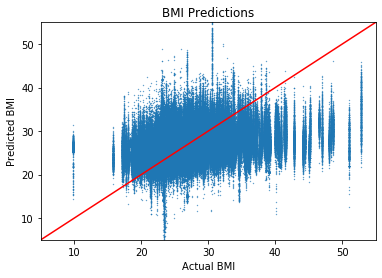

MemoryError: 

In [29]:
plt.figure()
plt.scatter(y_val, y_pred, s=0.1)
plt.plot([5, 55], [5, 55], 'r-')
plt.xlim([5, 55])
plt.ylim([5, 55])
plt.title("BMI Predictions")
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.show()

import scipy
print(scipy.stats.spearmanr(y_val, b=y_pred), 
      scipy.stats.pearsonr(x=y_val, y=y_pred))

In [30]:
#abs_err = np.abs(y_val - y_pred)
abs_err = 0
for i in range(len(y_val)):
    abs_err += abs(y_val[i] - y_pred[i])
abs_err = abs_err/len(y_val)
abs_err

array([3.93098763])

# Do user level scoring

In [31]:
unique_ids = np.unique(ids_val)
print(f'There are {len(unique_ids)} unique ids in our val set.')

overall_y_true = []
overall_y_pred = []

for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(ids_val == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    pred = np.mean(y_pred[usr_idxs])
    true = y_val[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')
    
    overall_y_true.append(true)
    overall_y_pred.append(pred)
    
overall_abs_err = np.abs(np.array(overall_y_true) - np.array(overall_y_pred))

There are 929 unique ids in our val set.


In [32]:
np.mean(overall_abs_err)

3.4916066643326507

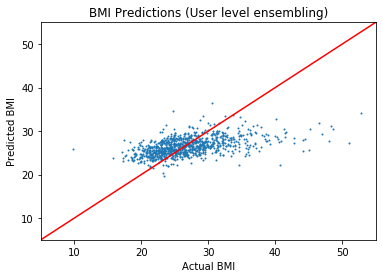

SpearmanrResult(correlation=0.5202433714675475, pvalue=1.4817746858492244e-65) (0.4770637842880696, 5.697288037431534e-54)


In [33]:
plt.figure()
plt.scatter(overall_y_true, overall_y_pred, s = 1)
plt.plot([5, 55], [5, 55], 'r-')
plt.xlim([5, 55])
plt.ylim([5, 55])
plt.title("BMI Predictions (User level ensembling)")
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.show()

import scipy
print(scipy.stats.spearmanr(overall_y_true, b=overall_y_pred), 
      scipy.stats.pearsonr(x=overall_y_true, y=overall_y_pred))

# That's it folks!

In [34]:
#Save the model
model.save("vinnet_BMI_15.h5")